<a href="https://colab.research.google.com/github/sftSalman/CNN/blob/main/SIGN_language_detection_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import h5py
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader, TensorDataset


def get_data(batch_size=64):
    train_dataset = h5py.File('/content/drive/MyDrive/Deep Learning/pytorch/datasets/train_signs.h5', "r")
    x_train = np.array(train_dataset["train_set_x"][:]) # your train set features
    x_train = np.transpose(x_train, (0, 3, 1, 2))
    y_train = np.array(train_dataset["train_set_y"][:]) # your train set labels
    y_train = y_train.reshape((1, y_train.shape[0])).T

    test_dataset = h5py.File('/content/drive/MyDrive/Deep Learning/pytorch/datasets/test_signs.h5', "r")
    x_test = np.array(test_dataset["test_set_x"][:]) # your test set features
    x_test = np.transpose(x_test, (0, 3, 1, 2))
    y_test = np.array(test_dataset["test_set_y"][:]) # your test set labels
    y_test = y_test.reshape((1, y_test.shape[0])).T

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    X_train_tensor = torch.tensor(x_train, dtype=torch.float)/255
    Y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    X_test_tensor = torch.tensor(x_test, dtype=torch.float)/255
    Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


    return train_dataset, test_dataset, train_loader, test_loader, classes


def path_to_input(image_path, input_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (input_size, input_size))                  #Resize
    img = img[..., ::-1].transpose((2, 0, 1))                        #BGR -> RGB and HxWxC -> CxHxW
    img = img[np.newaxis, ...] / 255.0                               #Add a channel at 0, thus making it a batch
    img = torch.tensor(img, dtype=torch.float)        #Convert to Tensor
    return img

In [2]:
#from cnn_utils import *
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import PIL
from scipy import ndimage


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


%load_ext autoreload
%autoreload 2

%matplotlib inline
np.random.seed(1)

In [3]:
train_dataset, test_dataset, train_loader, test_loader, classes = get_data(batch_size=64)

In [4]:
print(train_dataset)

y = 2


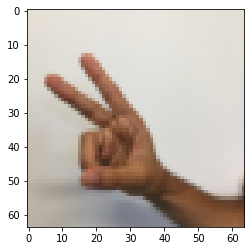

In [5]:
index = 6
img = train_dataset[index][0].numpy().transpose([1, 2, 0])
plt.imshow(img)
print ("y =", str(np.squeeze(train_dataset[index][1].numpy())))

In [6]:
print ("number of training examples =", len(train_dataset))
print ("number of test examples =", len(test_dataset))
print ("shape of a batch of train dataset examples:", next(iter(train_loader))[0].shape)
print ("shape of a batch of train dataset labels:", next(iter(train_loader))[1].shape)

number of training examples = 1080
number of test examples = 120
shape of a batch of train dataset examples: torch.Size([64, 3, 64, 64])
shape of a batch of train dataset labels: torch.Size([64, 1])


In [7]:
model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(2048, 6)
)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [15]:
def get_accuracy(model, loader):
    model.eval()
    num_samples = 0
    num_correct = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x, y = x, y
            y_pred = model(x)
            _, preds = y_pred.data.max(1)
            num_samples += preds.size(0)
            num_correct += (y.view(-1) == preds).sum()
        
    return num_correct.item() / num_samples

In [16]:
def train(model, test_loader, train_loader, epochs = 100, print_every=10):
    model.train()
    for e in range(1, epochs+1):
        if e % print_every == 0:
            print(f'Epoch {e} | Test Accuracy: {get_accuracy(model, test_loader)} | Train Accuracy: {get_accuracy(model, train_loader)}')
        for i, (x, y) in enumerate(train_loader):
            x, y = x, y
            y_pred = model(x)
            loss = loss_fn(y_pred, y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [17]:
train(model, test_loader, train_loader, epochs=100)


Epoch 10 | Test Accuracy: 0.5583333333333333 | Train Accuracy: 0.5879629629629629
Epoch 20 | Test Accuracy: 0.725 | Train Accuracy: 0.7092592592592593
Epoch 30 | Test Accuracy: 0.7833333333333333 | Train Accuracy: 0.762962962962963
Epoch 40 | Test Accuracy: 0.7916666666666666 | Train Accuracy: 0.7972222222222223
Epoch 50 | Test Accuracy: 0.8416666666666667 | Train Accuracy: 0.8212962962962963
Epoch 60 | Test Accuracy: 0.825 | Train Accuracy: 0.85
Epoch 70 | Test Accuracy: 0.8416666666666667 | Train Accuracy: 0.862037037037037
Epoch 80 | Test Accuracy: 0.8666666666666667 | Train Accuracy: 0.8907407407407407
Epoch 90 | Test Accuracy: 0.8583333333333333 | Train Accuracy: 0.8925925925925926
Epoch 100 | Test Accuracy: 0.8333333333333334 | Train Accuracy: 0.8962962962962963


Predicted class: 3


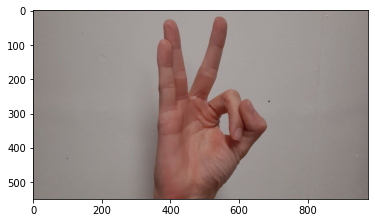

In [23]:
im_path = "/content/drive/MyDrive/Deep Learning/pytorch/images/1.jpg"
#/content/drive/MyDrive/Deep Learning/pytorch/images/1.jpg
plt.imshow(plt.imread(im_path))

inp = path_to_input(im_path, 64)
y_pred = model(inp)
_, y_pred_cls = y_pred.data.max(1)
print('Predicted class:', y_pred_cls[0].item())